<h1>Youtube Comments Spam Detection</h1>

Using comments scraped from Youtube utilizing the Youtube API on top youtubers and other comments from the UCI Machine Learning Repository, I will be creating a youtube comments spam detector using a Naive Bayes Classifier Machine Learning model. 

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from googleapiclient.discovery import build
from dotenv import load_dotenv
import os

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [22]:
# Downloading Stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/kevin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
# Getting api_key from environment variable
load_dotenv()
api_key = os.getenv('api_key')

# Creating build object for Youtube
youtube = build('youtube', 'v3', developerKey=api_key)

In [25]:
def get_video_ids(youtube, playlist_id):
    video_ids = []
    
    request = youtube.playlistItems().list(
        part='contentDetails',
        playlistId=playlist_id,
        maxResults = 50
    )
    
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part='contentDetails',
            playlistId = playlist_id,
            maxResults = 50,
            pageToken = next_page_token
        )
        response = request.execute()
        
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
            
        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [26]:
def get_playlists(youtube, channel_ids):
    upload_playlists = []
    
    request = youtube.channels().list(
        part='contentDetails',
        id=','.join(channel_ids)
    )
    
    response = request.execute()
    
    for item in response['items']:
        upload_playlists.append(item['contentDetails']['relatedPlaylists']['uploads'])
        
    return upload_playlists

In [27]:
def get_comments_in_videos(youtube, video_ids):
    comments = np.array([])
    
    for video_id in video_ids:
        request = youtube.commentThreads().list(
            part='snippet,replies',
            videoId=video_id,
            order = 'time',
            maxResults = 100
        )
        response = request.execute()
        
        comments_in_video = [
            comment['snippet']['topLevelComment']['snippet']['textOriginal']
            for comment in response['items']
        ]
        comments = np.append(comments, comments_in_video)
        
        while response:   
            comments_in_video = [
                comment['snippet']['topLevelComment']['snippet']['textOriginal']
                for comment in response['items']
            ]
            comments = np.append(comments, comments_in_video)
            
            if 'nextPageToken' in response:
                request = youtube.commentThreads().list(
                    part='snippet,replies',
                    videoId=video_id,
                    order = 'time',
                    maxResults = 100,
                    pageToken=response['nextPageToken']
                )
                response = request.execute()
            else:
                break
                
            if len(set(comments)) > 2000:
                break
                
    return list(set(comments))

In [28]:
# Processes and tokenizes the text
def process_text(text): 
    out = re.sub(r'[^\w\s]', '', text) # Removing Punctuation
    out = [word for word in out.split() if word.lower() not in stopwords.words('english')] # Removes Stopwords
    return out

In [373]:
# Getting upload playlist from channel_id
channel_ids = [
    'UCX6OQ3DkcsbYNE6H8uQQuVA', # MrBeast
    'UCoOjH8D2XAgjzQlneM2W0EQ', # JakeTran
    'UCgv4dPk_qZNAbUW9WkuLPSA', # Atrioc
    'UCYzPXprvl5Y-Sf0g4vX-m6g', # Jacksepticeye
    'UCBJycsmduvYEL83R_U4JriQ'  # Marques Brownlee
]
playlists = get_playlists(youtube, channel_ids)

In [685]:
# Getting all video ids for each Youtuber
jacksepticeye_video_ids = get_video_ids(youtube, playlists[0])
mr_beast_video_ids = get_video_ids(youtube, playlists[1])
marques_brownlee_video_ids = get_video_ids(youtube, playlists[2])
jake_tran_video_ids = get_video_ids(youtube, playlists[3])
atrioc_video_ids = get_video_ids(youtube, playlists[4])

In [688]:
# Number of videos for each Youtuber
print('Number of Jacksepticeye Videos: ', len(jacksepticeye_video_ids))
print('Number of MrBeast Videos: ', len(mr_beast_video_ids))
print('Number of Marques Brownlee Videos: ', len(marques_brownlee_video_ids))
print('Number of Jake Tran Videos: ', len(jake_tran_video_ids))
print('Number of Atrioc Videos: ', len(atrioc_video_ids))

Number of Jacksepticeye Videos:  4979
Number of MrBeast Videos:  723
Number of Marques Brownlee Videos:  1449
Number of Jake Tran Videos:  203
Number of Atrioc Videos:  615


In [716]:
# Only getting roughly at most 2000 comments from Youtuber's Latest Video
jacksepticeye_comments = get_comments_in_videos(youtube, [jacksepticeye_video_ids[0]])
mr_beast_comments = get_comments_in_videos(youtube, [mr_beast_video_ids[0]])
marques_brownlee_comments = get_comments_in_videos(youtube, [marques_brownlee_video_ids[0]])
jake_tran_comments = get_comments_in_videos(youtube, [jake_tran_video_ids[1]])
atrioc_comments = get_comments_in_videos(youtube, [atrioc_video_ids[1]])
# At the time, Jake Tran and Atrioc's Latest Video just came out so decided to use second latest video

In [717]:
# Combing all comments
combined_comments = (
    jacksepticeye_comments +
    mr_beast_comments + 
    marques_brownlee_comments + 
    jake_tran_comments +
    atrioc_comments
)

In [724]:
# Initial Setup of Comments DataFrame
youtube_comments = pd.DataFrame(
    data = {'comment': combined_comments, 'is_spam': [np.nan for i in range(len(combined_comments))]}
)
youtube_comments.to_csv('youtube_comments.csv', index = False)
youtube_comments

,comment,is_spam
0,Cats can eat grass it helps them when there st...,NaN
1,I can't wait for Part 2 on this :D look's awes...,NaN
2,"Its okay about the poncho Jack, you return to ...",NaN
3,Jack you forgot to find the first few memory s...,NaN
4,"I really hope Jack plays Sky some day, I reall...",NaN
...,...,...
7982,"Forgot Paper Mario, classic mistake",NaN
7983,what?!?,NaN
7984,I was not ready for him stabbing himself,NaN
7985,I love the sound of falling onto a window in M...,NaN


In [273]:
# Labeling Comments if Spam or Not
youtube_comment_temp = pd.read_csv('youtube_comments.csv')
for i in range(youtube_comment_temp.shape[0]):
    if np.isnan(youtube_comment_temp['is_spam'].iloc[i]):
        print(youtube_comment_temp.iloc[i]['comment'])
        is_spam = input()
        if is_spam in ['0', '1']:
            youtube_comment_temp['is_spam'].iloc[i] = is_spam
        elif is_spam in ['2']:
            youtube_comment_temp['is_spam'].iloc[i] = 2
        else:
            break
youtube_comment_temp.to_csv('youtube_comments.csv', index = False)

In [268]:
# Retrieving labeled comments
labeled_data = pd.read_csv('youtube_comments.csv')
labeled_data

,comment,is_spam
0,Cats can eat grass it helps them when there st...,0.0
1,I can't wait for Part 2 on this :D look's awes...,0.0
2,"Its okay about the poncho Jack, you return to ...",0.0
3,Jack you forgot to find the first few memory s...,0.0
4,"I really hope Jack plays Sky some day, I reall...",0.0
...,...,...
7983,"Forgot Paper Mario, classic mistake",0.0
7984,what?!?,0.0
7985,I was not ready for him stabbing himself,0.0
7986,I love the sound of falling onto a window in M...,0.0


In [269]:
# Number of valid data
sum(labeled_data['is_spam'] < 2)

7792

In [270]:
# Number of "invalid" data, where invalid is gibberish or non-english
labeled_data[labeled_data['is_spam'] == 2].shape[0]

196

In [271]:
# Number of Not-Spam
labeled_data[labeled_data['is_spam'] == 0].shape[0]

7506

In [272]:
# Number of Spam
labeled_data[labeled_data['is_spam'] == 1].shape[0]

286

To get more data for spam comments, I utilized the UCI Machine Learning Repository to gather more spam comments.
https://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection

In [274]:
# Importing data from UCI Machine Learning Repository
psy_data = pd.read_csv('YouTube-Spam-Collection-v1/Youtube01-Psy.csv')[['CONTENT', 'CLASS']]
katy_perry_data = pd.read_csv('YouTube-Spam-Collection-v1/Youtube02-KatyPerry.csv')[['CONTENT', 'CLASS']]
lmfao_data = pd.read_csv('YouTube-Spam-Collection-v1/Youtube03-LMFAO.csv')[['CONTENT', 'CLASS']]
eminem_data = pd.read_csv('YouTube-Spam-Collection-v1/Youtube04-Eminem.csv')[['CONTENT', 'CLASS']]
shakira_data = pd.read_csv('YouTube-Spam-Collection-v1/Youtube05-Shakira.csv')[['CONTENT', 'CLASS']]

In [275]:
# Concat all spam comments, standardizing column names, filter only spam comments
spam_data = pd.concat([psy_data, katy_perry_data, lmfao_data, eminem_data, shakira_data])
spam_comments = spam_data.rename(columns={'CONTENT':'comment', 'CLASS':'is_spam'})[spam_data['CLASS'] == 1]
spam_comments

,comment,is_spam
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1
...,...,...
357,********OMG Facebook is OLD! Check out ------...,1
358,Hey Music Fans I really appreciate all of you ...,1
359,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,1
360,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,1


<h2>Creating Spam Detection ML Model</h2>

In [276]:
filtered_data = pd.concat([labeled_data[labeled_data['is_spam'] < 2], spam_comments]).dropna()
filtered_data

,comment,is_spam
0,Cats can eat grass it helps them when there st...,0.0
1,I can't wait for Part 2 on this :D look's awes...,0.0
2,"Its okay about the poncho Jack, you return to ...",0.0
3,Jack you forgot to find the first few memory s...,0.0
4,"I really hope Jack plays Sky some day, I reall...",0.0
...,...,...
357,********OMG Facebook is OLD! Check out ------...,1.0
358,Hey Music Fans I really appreciate all of you ...,1.0
359,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,1.0
360,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,1.0


Number of Spam:  7506
Number of Not-Spam:  1290


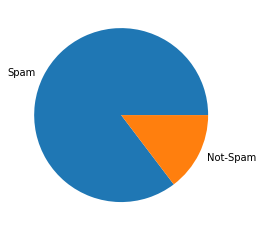

Perentage of Spam:  0.85
Perentage of Spam:  0.15


In [300]:
# Plotting Pie Chart of Proportion of Spam and Not-Spam Comments
labels = ['Spam', 'Not-Spam']
values = [sum(filtered_data['is_spam'] == 0), sum(filtered_data['is_spam'] == 1)]

plt.pie(values, labels = labels)

print('Number of Spam: ', sum(filtered_data['is_spam'] == 0))
print('Number of Not-Spam: ', sum(filtered_data['is_spam'] == 1))
plt.show()
print('Perentage of Spam: ', round(sum(filtered_data['is_spam'] == 0) / filtered_data.shape[0], 2))
print('Perentage of Spam: ', round(sum(filtered_data['is_spam'] == 1) / filtered_data.shape[0], 2))

In [314]:
# Convert text to matrix of token counts
bag_of_words = CountVectorizer(analyzer=process_text).fit_transform(filtered_data['comment'])

In [319]:
# Splitting data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(
    bag_of_words,
    filtered_data['is_spam'],
    test_size = 0.3,
)

In [320]:
# Creating and training Naive Bayes Classifier
classifier = MultinomialNB().fit(X_train, y_train)

<h2>Evaluating Model on Training Data Set</h2>

In [321]:
pred_train = classifier.predict(X_train)
print('Classification Report: \n', classification_report(y_train, pred_train))
print('Confusion matrix: \n', confusion_matrix(y_train, pred_train), '\n')
print('Accuracy: \n', accuracy_score(y_train, pred_train))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      5235
         1.0       0.93      0.85      0.89       922

    accuracy                           0.97      6157
   macro avg       0.95      0.92      0.94      6157
weighted avg       0.97      0.97      0.97      6157

Confusion matrix: 
 [[5180   55]
 [ 137  785]] 

Accuracy: 
 0.9688159818093227


<h2>Evaluating Model on Test Data Set</h2>

In [322]:
pred_test = classifier.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred_test))
print('Confusion matrix: \n', confusion_matrix(y_test, pred_test), '\n')
print('Accuracy: \n', accuracy_score(y_test, pred_test))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      2271
         1.0       0.75      0.79      0.77       368

    accuracy                           0.93      2639
   macro avg       0.86      0.87      0.86      2639
weighted avg       0.94      0.93      0.93      2639

Confusion matrix: 
 [[2175   96]
 [  79  289]] 

Accuracy: 
 0.9336870026525199
